In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 1. Import Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Evaluation metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, precision_score,
    recall_score, f1_score, accuracy_score, matthews_corrcoef,
    cohen_kappa_score, log_loss, brier_score_loss
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import learning_curve, validation_curve

# Statistical tests
from scipy import stats
from scipy.stats import chi2_contingency

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')

### 2. Load Models and Data

In [5]:
# Load test data
X_test = pd.read_csv('artifacts/data/X_test.csv')
y_test = pd.read_csv('artifacts/data/y_test.csv')['y_test'].values

print(f"Test set loaded: {X_test.shape}")
print(f"Test labels: {len(y_test)}")
print(f"Test set churn rate: {y_test.mean():.3f}")

# Load all ensemble models
model_files = {
    'Random Forest': r'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\notebooks\artifacts\models\random_forest_optimized.pkl',
    'XGBoost': r'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\notebooks\artifacts\models\xgboost_optimized.pkl', 
    'CatBoost': r'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\notebooks\artifacts\models\catboost_optimized.pkl',
    'Voting Ensemble': r'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\notebooks\artifacts\models\voting_ensemble.pkl'
}

models = {}
for model_name, filepath in model_files.items():
    if os.path.exists(filepath):
        models[model_name] = joblib.load(filepath)
        print(f"✅ Loaded {model_name}")
    else:
        print(f"❌ Could not find {filepath}")

print(f"\nLoaded {len(models)} models for evaluation")

Test set loaded: (1409, 30)
Test labels: 1409
Test set churn rate: 0.265
✅ Loaded Random Forest
✅ Loaded XGBoost
✅ Loaded CatBoost
✅ Loaded Voting Ensemble

Loaded 4 models for evaluation


### 3. Generate Predictions for All Models

In [6]:
# Generate predictions for all models
predictions = {}
prediction_probabilities = {}

print("Generating predictions for all models...")
for model_name, model in models.items():
    try:
        # Get predictions
        pred = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)[:, 1]
        
        predictions[model_name] = pred
        prediction_probabilities[model_name] = pred_proba
        
        print(f"✅ Generated predictions for {model_name}")
    except Exception as e:
        print(f"❌ Failed to generate predictions for {model_name}: {e}")

print(f"\nPredictions generated for {len(predictions)} models")

Generating predictions for all models...
✅ Generated predictions for Random Forest
✅ Generated predictions for XGBoost
✅ Generated predictions for CatBoost
✅ Generated predictions for Voting Ensemble

Predictions generated for 4 models


### 4. Comprehensive Metrics Calculation

In [7]:
# Calculate comprehensive metrics for all models
def calculate_comprehensive_metrics(y_true, y_pred, y_pred_proba):
    """Calculate comprehensive evaluation metrics for imbalanced classification"""
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred)
    metrics['specificity'] = recall_score(y_true, y_pred, pos_label=0)
    
    # ROC and PR metrics
    metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    metrics['pr_auc'] = average_precision_score(y_true, y_pred_proba)
    
    # Additional metrics for imbalanced data
    metrics['matthews_cc'] = matthews_corrcoef(y_true, y_pred)
    metrics['cohen_kappa'] = cohen_kappa_score(y_true, y_pred)
    
    # Probabilistic metrics
    metrics['log_loss'] = log_loss(y_true, y_pred_proba)
    metrics['brier_score'] = brier_score_loss(y_true, y_pred_proba)
    
    # Balanced accuracy
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['balanced_accuracy'] = (tp/(tp+fn) + tn/(tn+fp)) / 2
    
    # Business-relevant metrics
    metrics['true_positive_rate'] = tp/(tp+fn)  # Sensitivity/Recall
    metrics['false_positive_rate'] = fp/(fp+tn)
    metrics['positive_predictive_value'] = tp/(tp+fp)  # Precision
    metrics['negative_predictive_value'] = tn/(tn+fn)
    
    return metrics

# Calculate metrics for all models
all_metrics = {}
for model_name in predictions.keys():
    metrics = calculate_comprehensive_metrics(
        y_test, 
        predictions[model_name], 
        prediction_probabilities[model_name]
    )
    all_metrics[model_name] = metrics

print("✅ Comprehensive metrics calculated for all models")

✅ Comprehensive metrics calculated for all models


In [8]:
# Create comprehensive metrics comparison table
metrics_df = pd.DataFrame(all_metrics).T

print("COMPREHENSIVE MODEL EVALUATION METRICS")
print("=" * 65)
print(metrics_df.round(4))

# Identify best models for key metrics
key_metrics = ['f1', 'roc_auc', 'pr_auc', 'matthews_cc', 'balanced_accuracy']
print("\nBEST MODELS BY KEY METRICS:")
print("=" * 35)
for metric in key_metrics:
    best_model = metrics_df[metric].idxmax()
    best_score = metrics_df.loc[best_model, metric]
    print(f"{metric.upper():<18}: {best_model:<20} ({best_score:.4f})")

COMPREHENSIVE MODEL EVALUATION METRICS
                 accuracy  precision  recall     f1  specificity  roc_auc  \
Random Forest      0.7559     0.5283  0.7487 0.6195       0.7585   0.8364   
XGBoost            0.7842     0.5983  0.5695 0.5836       0.8618   0.8347   
CatBoost           0.7842     0.5907  0.6096 0.6000       0.8473   0.8426   
Voting Ensemble    0.7821     0.5844  0.6203 0.6018       0.8406   0.8446   

                 pr_auc  matthews_cc  cohen_kappa  log_loss  brier_score  \
Random Forest    0.6200       0.4623       0.4475    0.4973       0.1643   
XGBoost          0.6308       0.4383       0.4381    0.4443       0.1435   
CatBoost         0.6530       0.4524       0.4523    0.4273       0.1408   
Voting Ensemble  0.6503       0.4524       0.4520    0.4355       0.1420   

                 balanced_accuracy  true_positive_rate  false_positive_rate  \
Random Forest               0.7536              0.7487               0.2415   
XGBoost                     0.7157  

### 5. Confusion Matrix Analysis

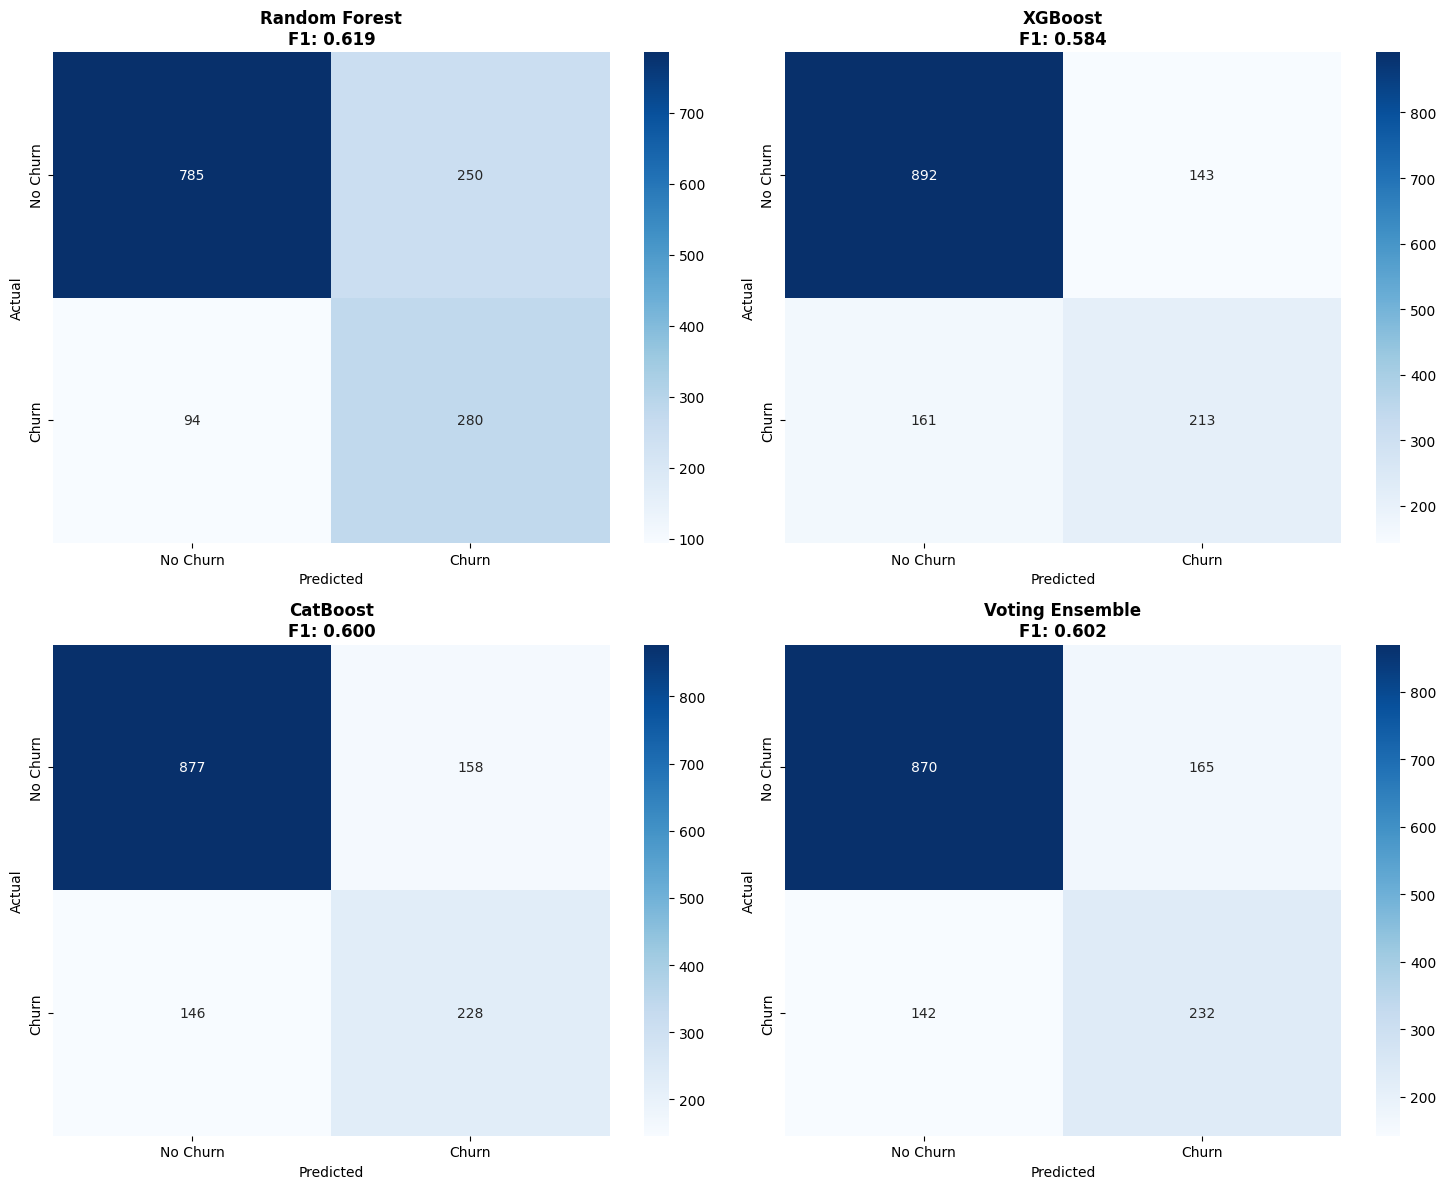

CONFUSION MATRIX ANALYSIS

Random Forest:
  True Negatives (Correct No Churn): 785
  False Positives (Incorrect Churn): 250
  False Negatives (Missed Churn): 94
  True Positives (Correct Churn): 280
  Total Predictions: 1,409

XGBoost:
  True Negatives (Correct No Churn): 892
  False Positives (Incorrect Churn): 143
  False Negatives (Missed Churn): 161
  True Positives (Correct Churn): 213
  Total Predictions: 1,409

CatBoost:
  True Negatives (Correct No Churn): 877
  False Positives (Incorrect Churn): 158
  False Negatives (Missed Churn): 146
  True Positives (Correct Churn): 228
  Total Predictions: 1,409

Voting Ensemble:
  True Negatives (Correct No Churn): 870
  False Positives (Incorrect Churn): 165
  False Negatives (Missed Churn): 142
  True Positives (Correct Churn): 232
  Total Predictions: 1,409


In [9]:
# Create confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (model_name, pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'],
                ax=axes[i])
    axes[i].set_title(f'{model_name}\nF1: {all_metrics[model_name]["f1"]:.3f}', 
                     fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Print detailed confusion matrix analysis
print("CONFUSION MATRIX ANALYSIS")
print("=" * 40)
for model_name, pred in predictions.items():
    cm = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{model_name}:")
    print(f"  True Negatives (Correct No Churn): {tn:,}")
    print(f"  False Positives (Incorrect Churn): {fp:,}")
    print(f"  False Negatives (Missed Churn): {fn:,}")
    print(f"  True Positives (Correct Churn): {tp:,}")
    print(f"  Total Predictions: {tn+fp+fn+tp:,}")

### 6. ROC Curve Analysis

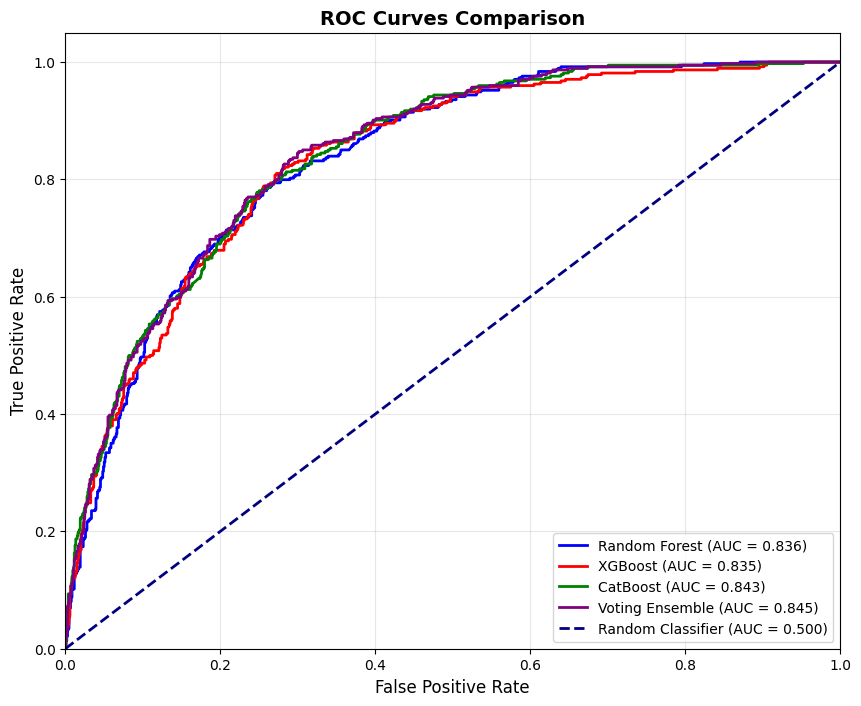

ROC-AUC SCORES RANKING:
1. Voting Ensemble     : 0.8446
2. CatBoost            : 0.8426
3. Random Forest       : 0.8364
4. XGBoost             : 0.8347


In [10]:
# ROC Curve comparison
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'purple']
for i, (model_name, pred_proba) in enumerate(prediction_probabilities.items()):
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{model_name} (AUC = {roc_auc:.3f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print ROC AUC scores
print("ROC-AUC SCORES RANKING:")
print("=" * 30)
roc_scores = [(name, all_metrics[name]['roc_auc']) for name in all_metrics.keys()]
roc_scores.sort(key=lambda x: x[1], reverse=True)

for i, (model_name, score) in enumerate(roc_scores, 1):
    print(f"{i}. {model_name:<20}: {score:.4f}")

### 7. Precision-Recall Curve Analysis

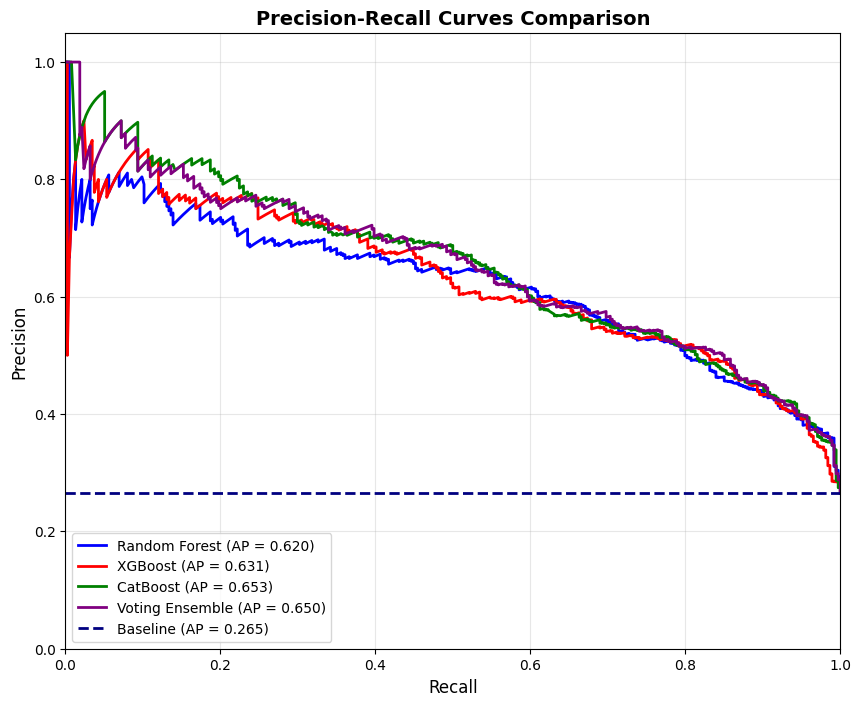

PRECISION-RECALL AUC SCORES RANKING:
1. CatBoost            : 0.6530
2. Voting Ensemble     : 0.6503
3. XGBoost             : 0.6308
4. Random Forest       : 0.6200

Baseline (Random Classifier): 0.2654
Best improvement over baseline: 0.3876


In [11]:
# Precision-Recall Curve comparison
plt.figure(figsize=(10, 8))

baseline_precision = y_test.mean()  # Random classifier baseline

for i, (model_name, pred_proba) in enumerate(prediction_probabilities.items()):
    precision, recall, _ = precision_recall_curve(y_test, pred_proba)
    pr_auc = average_precision_score(y_test, pred_proba)
    
    plt.plot(recall, precision, color=colors[i], lw=2, 
             label=f'{model_name} (AP = {pr_auc:.3f})')

# Plot baseline
plt.axhline(y=baseline_precision, color='navy', linestyle='--', lw=2,
           label=f'Baseline (AP = {baseline_precision:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

# Print PR AUC scores
print("PRECISION-RECALL AUC SCORES RANKING:")
print("=" * 40)
pr_scores = [(name, all_metrics[name]['pr_auc']) for name in all_metrics.keys()]
pr_scores.sort(key=lambda x: x[1], reverse=True)

for i, (model_name, score) in enumerate(pr_scores, 1):
    print(f"{i}. {model_name:<20}: {score:.4f}")

print(f"\nBaseline (Random Classifier): {baseline_precision:.4f}")
print(f"Best improvement over baseline: {pr_scores[0][1] - baseline_precision:.4f}")

### 8. Threshold Optimization Analysis

Threshold Optimization for: Random Forest


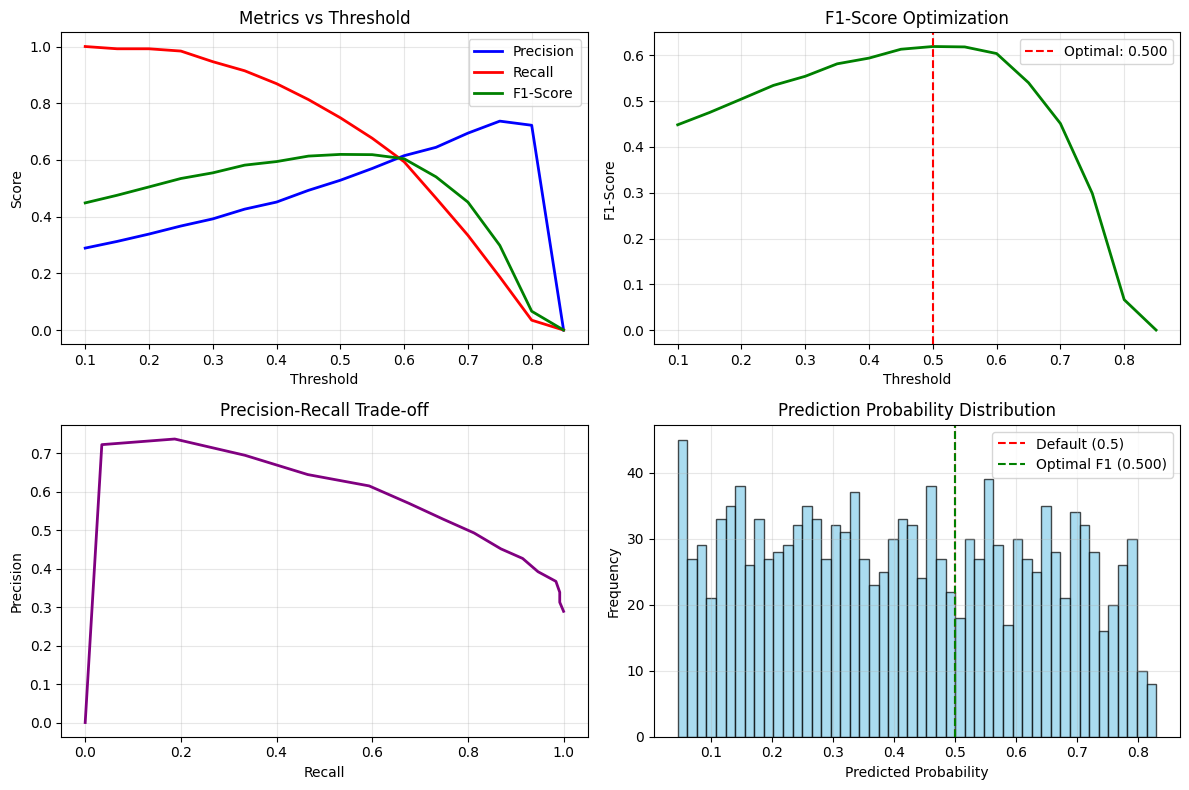

Optimal F1 Threshold: 0.500
Optimal F1 Score: 0.6195
Default Threshold (0.5) F1 Score: 0.6195
Improvement: 0.0000


In [12]:
# Threshold optimization for best model
best_f1_model = metrics_df['f1'].idxmax()
best_pred_proba = prediction_probabilities[best_f1_model]

print(f"Threshold Optimization for: {best_f1_model}")
print("=" * 50)

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_metrics = []

for threshold in thresholds:
    y_pred_thresh = (best_pred_proba >= threshold).astype(int)
    
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    threshold_metrics.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Plot threshold optimization
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['f1'], 'g-', label='F1-Score', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Find optimal thresholds
optimal_f1_idx = threshold_df['f1'].idxmax()
optimal_f1_threshold = threshold_df.loc[optimal_f1_idx, 'threshold']
optimal_f1_score = threshold_df.loc[optimal_f1_idx, 'f1']

plt.subplot(2, 2, 2)
plt.plot(threshold_df['threshold'], threshold_df['f1'], 'g-', linewidth=2)
plt.axvline(x=optimal_f1_threshold, color='red', linestyle='--', 
           label=f'Optimal: {optimal_f1_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score Optimization')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall trade-off
plt.subplot(2, 2, 3)
plt.plot(threshold_df['recall'], threshold_df['precision'], 'purple', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Trade-off')
plt.grid(True, alpha=0.3)

# Threshold distribution
plt.subplot(2, 2, 4)
plt.hist(best_pred_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', label='Default (0.5)')
plt.axvline(x=optimal_f1_threshold, color='green', linestyle='--', 
           label=f'Optimal F1 ({optimal_f1_threshold:.3f})')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Optimal F1 Threshold: {optimal_f1_threshold:.3f}")
print(f"Optimal F1 Score: {optimal_f1_score:.4f}")
print(f"Default Threshold (0.5) F1 Score: {all_metrics[best_f1_model]['f1']:.4f}")
print(f"Improvement: {optimal_f1_score - all_metrics[best_f1_model]['f1']:.4f}")

### 9. Statistical Significance Testing

In [13]:
# McNemar's test for comparing models
from scipy.stats import chi2

def mcnemar_test(y_true, pred1, pred2, model1_name, model2_name):
    """Perform McNemar's test to compare two models"""
    # Create contingency table
    correct1 = (pred1 == y_true)
    correct2 = (pred2 == y_true)
    
    # McNemar's table
    both_correct = np.sum(correct1 & correct2)
    model1_only = np.sum(correct1 & ~correct2)
    model2_only = np.sum(~correct1 & correct2)
    both_wrong = np.sum(~correct1 & ~correct2)
    
    # McNemar's test statistic
    if model1_only + model2_only == 0:
        return None, None, "No disagreement between models"
    
    chi2_stat = ((model1_only - model2_only) ** 2) / (model1_only + model2_only)
    p_value = 1 - chi2.cdf(chi2_stat, 1)
    
    result = {
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'both_correct': both_correct,
        'model1_only': model1_only,
        'model2_only': model2_only,
        'both_wrong': both_wrong,
        'significant': p_value < 0.05
    }
    
    return result

# Perform pairwise McNemar tests
print("MCNEMAR'S TEST FOR MODEL COMPARISON")
print("=" * 45)
print("Tests statistical significance of performance differences\n")

model_names = list(predictions.keys())
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        model1_name = model_names[i]
        model2_name = model_names[j]
        
        result = mcnemar_test(
            y_test, 
            predictions[model1_name], 
            predictions[model2_name],
            model1_name, 
            model2_name
        )
        
        if result:
            print(f"{model1_name} vs {model2_name}:")
            print(f"  Chi-square statistic: {result['chi2_statistic']:.4f}")
            print(f"  p-value: {result['p_value']:.4f}")
            print(f"  Statistically significant: {'Yes' if result['significant'] else 'No'}")
            print(f"  {model1_name} only correct: {result['model1_only']}")
            print(f"  {model2_name} only correct: {result['model2_only']}")
            print()

MCNEMAR'S TEST FOR MODEL COMPARISON
Tests statistical significance of performance differences

Random Forest vs XGBoost:
  Chi-square statistic: 7.2072
  p-value: 0.0073
  Statistically significant: Yes
  Random Forest only correct: 91
  XGBoost only correct: 131

Random Forest vs CatBoost:
  Chi-square statistic: 10.1266
  p-value: 0.0015
  Statistically significant: Yes
  Random Forest only correct: 59
  CatBoost only correct: 99

Random Forest vs Voting Ensemble:
  Chi-square statistic: 9.3129
  p-value: 0.0023
  Statistically significant: Yes
  Random Forest only correct: 55
  Voting Ensemble only correct: 92

XGBoost vs CatBoost:
  Chi-square statistic: 0.0000
  p-value: 1.0000
  Statistically significant: No
  XGBoost only correct: 58
  CatBoost only correct: 58

XGBoost vs Voting Ensemble:
  Chi-square statistic: 0.1111
  p-value: 0.7389
  Statistically significant: No
  XGBoost only correct: 42
  Voting Ensemble only correct: 39

CatBoost vs Voting Ensemble:
  Chi-square statis

### 10. Model Calibration Analysis

MODEL CALIBRATION ANALYSIS
Random Forest:
  Brier Score: 0.1643 (lower is better)
  Calibration Error: 0.1371

XGBoost:
  Brier Score: 0.1435 (lower is better)
  Calibration Error: 0.0723

CatBoost:
  Brier Score: 0.1408 (lower is better)
  Calibration Error: 0.0682

Voting Ensemble:
  Brier Score: 0.1420 (lower is better)
  Calibration Error: 0.0810



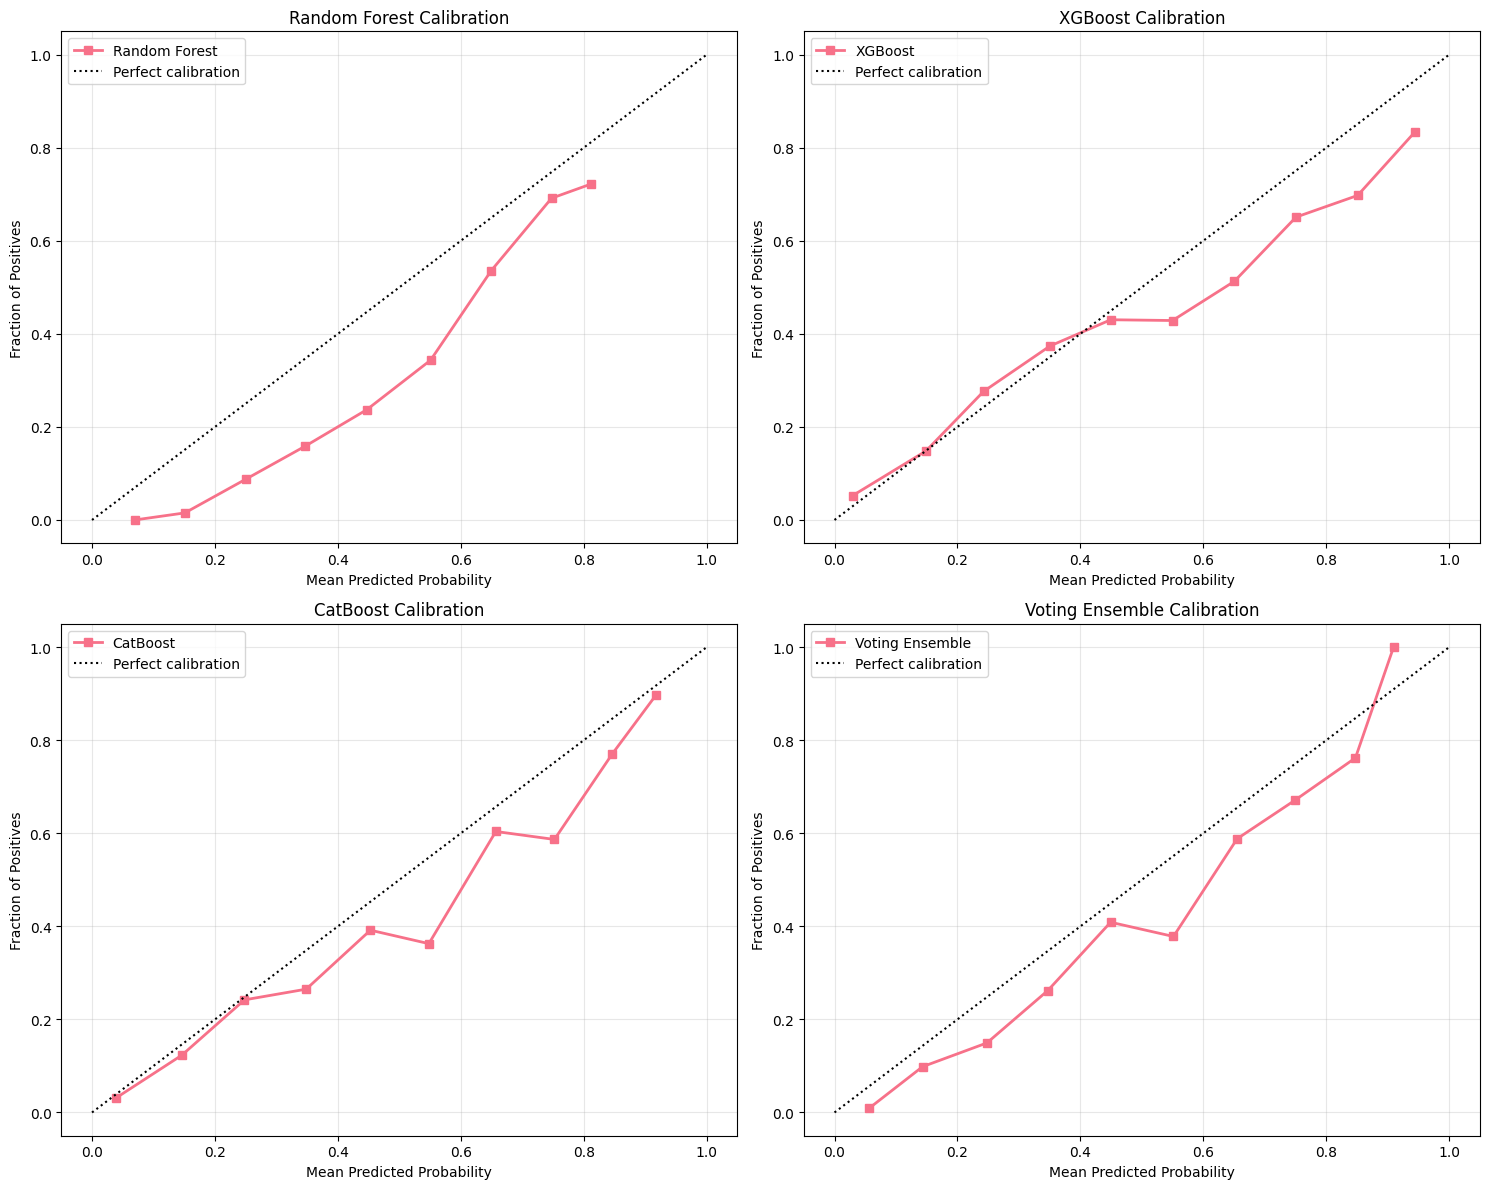

In [14]:
# Calibration plots for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

print("MODEL CALIBRATION ANALYSIS")
print("=" * 35)

for i, (model_name, pred_proba) in enumerate(prediction_probabilities.items()):
    # Calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, pred_proba, n_bins=10
    )
    
    # Plot calibration curve
    axes[i].plot(mean_predicted_value, fraction_of_positives, "s-", 
                linewidth=2, label=model_name)
    axes[i].plot([0, 1], [0, 1], "k:", label="Perfect calibration")
    axes[i].set_xlabel('Mean Predicted Probability')
    axes[i].set_ylabel('Fraction of Positives')
    axes[i].set_title(f'{model_name} Calibration')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Calculate calibration metrics
    brier_score = brier_score_loss(y_test, pred_proba)
    print(f"{model_name}:")
    print(f"  Brier Score: {brier_score:.4f} (lower is better)")
    print(f"  Calibration Error: {np.mean(np.abs(fraction_of_positives - mean_predicted_value)):.4f}")
    print()

plt.tight_layout()
plt.show()

### 11. Error Analysis

ERROR ANALYSIS FOR: Random Forest


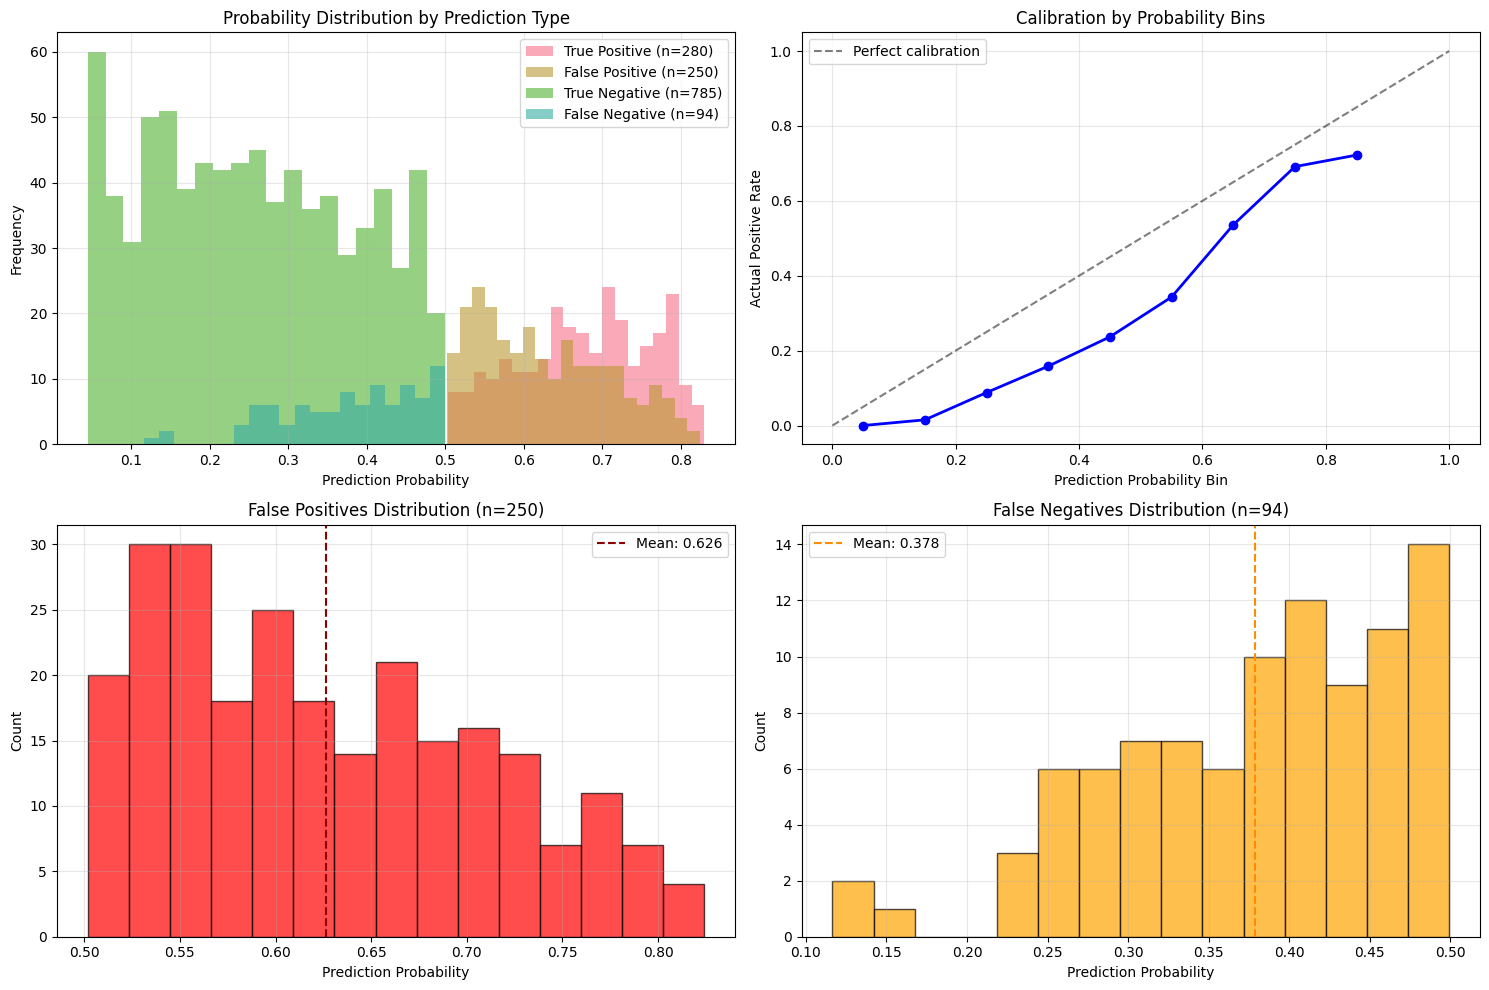

Error Type Counts:
error_type
True Negative     785
True Positive     280
False Positive    250
False Negative     94
Name: count, dtype: int64

False Positive Rate: 0.2415
False Negative Rate: 0.2513

Average confidence for False Positives: 0.626
Average confidence for False Negatives: 0.378


In [15]:
# Error analysis for the best model
best_model_name = best_f1_model
best_pred = predictions[best_model_name]
best_pred_proba = prediction_probabilities[best_model_name]

print(f"ERROR ANALYSIS FOR: {best_model_name}")
print("=" * 50)

# Identify different types of predictions
true_positives = (y_test == 1) & (best_pred == 1)
false_positives = (y_test == 0) & (best_pred == 1)
true_negatives = (y_test == 0) & (best_pred == 0)
false_negatives = (y_test == 1) & (best_pred == 0)

# Create error analysis DataFrame
error_analysis = pd.DataFrame({
    'actual': y_test,
    'predicted': best_pred,
    'probability': best_pred_proba,
    'error_type': np.where(
        true_positives, 'True Positive',
        np.where(
            false_positives, 'False Positive',
            np.where(
                true_negatives, 'True Negative',
                'False Negative'
            )
        )
    )
})

# Analyze prediction confidence by error type
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Probability distribution by error type
for error_type in ['True Positive', 'False Positive', 'True Negative', 'False Negative']:
    subset = error_analysis[error_analysis['error_type'] == error_type]
    if len(subset) > 0:
        axes[0, 0].hist(subset['probability'], bins=20, alpha=0.6, 
                       label=f'{error_type} (n={len(subset)})')

axes[0, 0].set_xlabel('Prediction Probability')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Probability Distribution by Prediction Type')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Error rates by probability bins
prob_bins = np.linspace(0, 1, 11)
error_analysis['prob_bin'] = pd.cut(error_analysis['probability'], prob_bins)
error_rates = error_analysis.groupby('prob_bin')['actual'].agg(['mean', 'count'])

bin_centers = [(prob_bins[i] + prob_bins[i+1])/2 for i in range(len(prob_bins)-1)]
axes[0, 1].plot(bin_centers, error_rates['mean'], 'bo-', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
axes[0, 1].set_xlabel('Prediction Probability Bin')
axes[0, 1].set_ylabel('Actual Positive Rate')
axes[0, 1].set_title('Calibration by Probability Bins')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: False Positive analysis
fp_probs = error_analysis[error_analysis['error_type'] == 'False Positive']['probability']
if len(fp_probs) > 0:
    axes[1, 0].hist(fp_probs, bins=15, alpha=0.7, color='red', edgecolor='black')
    axes[1, 0].axvline(fp_probs.mean(), color='darkred', linestyle='--', 
                      label=f'Mean: {fp_probs.mean():.3f}')
    axes[1, 0].set_xlabel('Prediction Probability')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title(f'False Positives Distribution (n={len(fp_probs)})')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Plot 4: False Negative analysis
fn_probs = error_analysis[error_analysis['error_type'] == 'False Negative']['probability']
if len(fn_probs) > 0:
    axes[1, 1].hist(fn_probs, bins=15, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].axvline(fn_probs.mean(), color='darkorange', linestyle='--', 
                      label=f'Mean: {fn_probs.mean():.3f}')
    axes[1, 1].set_xlabel('Prediction Probability')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title(f'False Negatives Distribution (n={len(fn_probs)})')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print error analysis summary
print("Error Type Counts:")
print(error_analysis['error_type'].value_counts())
print(f"\nFalse Positive Rate: {len(fp_probs) / (len(fp_probs) + np.sum(true_negatives)):.4f}")
print(f"False Negative Rate: {len(fn_probs) / (len(fn_probs) + np.sum(true_positives)):.4f}")
print(f"\nAverage confidence for False Positives: {fp_probs.mean():.3f}")
print(f"Average confidence for False Negatives: {fn_probs.mean():.3f}")

### 12. Save Evaluation Results

In [16]:
# Ensure reports directory exists
os.makedirs('artifacts/reports', exist_ok=True)

# Save comprehensive metrics
metrics_df.to_csv('artifacts/reports/comprehensive_evaluation_metrics.csv')
print("✅ Saved comprehensive metrics to: artifacts/reports/comprehensive_evaluation_metrics.csv")

# Save threshold optimization results
threshold_df.to_csv('artifacts/reports/threshold_optimization.csv', index=False)
print("✅ Saved threshold optimization to: artifacts/reports/threshold_optimization.csv")

# Save predictions for further analysis
predictions_df = pd.DataFrame(predictions)
predictions_df['actual'] = y_test
predictions_df.to_csv('artifacts/reports/model_predictions.csv', index=False)
print("✅ Saved predictions to: artifacts/reports/model_predictions.csv")

# Save prediction probabilities
probabilities_df = pd.DataFrame(prediction_probabilities)
probabilities_df['actual'] = y_test
probabilities_df.to_csv('artifacts/reports/model_probabilities.csv', index=False)
print("✅ Saved probabilities to: artifacts/reports/model_probabilities.csv")

# Create evaluation summary JSON
evaluation_summary = {
    'best_models': {
        'best_f1': {
            'model': metrics_df['f1'].idxmax(),
            'score': metrics_df['f1'].max()
        },
        'best_roc_auc': {
            'model': metrics_df['roc_auc'].idxmax(),
            'score': metrics_df['roc_auc'].max()
        },
        'best_pr_auc': {
            'model': metrics_df['pr_auc'].idxmax(),
            'score': metrics_df['pr_auc'].max()
        }
    },
    'optimal_threshold': {
        'model': best_f1_model,
        'threshold': float(optimal_f1_threshold),
        'f1_score': float(optimal_f1_score)
    },
    'evaluation_date': datetime.now().isoformat(),
    'test_set_size': len(y_test),
    'test_churn_rate': float(y_test.mean())
}

with open('artifacts/reports/evaluation_summary.json', 'w') as f:
    json.dump(evaluation_summary, f, indent=2)
print("✅ Saved evaluation summary to: artifacts/reports/evaluation_summary.json")

✅ Saved comprehensive metrics to: artifacts/reports/comprehensive_evaluation_metrics.csv
✅ Saved threshold optimization to: artifacts/reports/threshold_optimization.csv
✅ Saved predictions to: artifacts/reports/model_predictions.csv
✅ Saved probabilities to: artifacts/reports/model_probabilities.csv
✅ Saved evaluation summary to: artifacts/reports/evaluation_summary.json


### 13. Model Evaluation Summary

In [17]:
print("COMPREHENSIVE MODEL EVALUATION SUMMARY")
print("=" * 60)

print(f"\n📊 EVALUATION SCOPE:")
print(f"   • Models evaluated: {len(models)}")
print(f"   • Test set size: {len(y_test):,} customers")
print(f"   • Test set churn rate: {y_test.mean():.1%}")
print(f"   • Metrics calculated: {len(metrics_df.columns)}")

print(f"\n🏆 TOP PERFORMERS:")
best_f1_model = metrics_df['f1'].idxmax()
best_roc_model = metrics_df['roc_auc'].idxmax()
best_pr_model = metrics_df['pr_auc'].idxmax()
best_mcc_model = metrics_df['matthews_cc'].idxmax()

print(f"   • Best F1 Score: {best_f1_model} ({metrics_df.loc[best_f1_model, 'f1']:.4f})")
print(f"   • Best ROC-AUC: {best_roc_model} ({metrics_df.loc[best_roc_model, 'roc_auc']:.4f})")
print(f"   • Best PR-AUC: {best_pr_model} ({metrics_df.loc[best_pr_model, 'pr_auc']:.4f})")
print(f"   • Best Matthews CC: {best_mcc_model} ({metrics_df.loc[best_mcc_model, 'matthews_cc']:.4f})")

print(f"\n🎯 THRESHOLD OPTIMIZATION:")
print(f"   • Model: {best_f1_model}")
print(f"   • Default threshold (0.5): F1 = {all_metrics[best_f1_model]['f1']:.4f}")
print(f"   • Optimal threshold ({optimal_f1_threshold:.3f}): F1 = {optimal_f1_score:.4f}")
print(f"   • Improvement: {optimal_f1_score - all_metrics[best_f1_model]['f1']:.4f}")

print(f"\n📈 PERFORMANCE INSIGHTS:")
avg_f1 = metrics_df['f1'].mean()
avg_roc = metrics_df['roc_auc'].mean()
avg_pr = metrics_df['pr_auc'].mean()

print(f"   • Average F1 across models: {avg_f1:.4f}")
print(f"   • Average ROC-AUC across models: {avg_roc:.4f}")
print(f"   • Average PR-AUC across models: {avg_pr:.4f}")
print(f"   • Best model outperforms average by: {metrics_df['f1'].max() - avg_f1:.4f} F1 points")

print(f"\n🚨 ERROR ANALYSIS:")
cm = confusion_matrix(y_test, predictions[best_f1_model])
tn, fp, fn, tp = cm.ravel()
print(f"   • False Positives: {fp:,} ({fp/(fp+tn):.1%} of negatives)")
print(f"   • False Negatives: {fn:,} ({fn/(fn+tp):.1%} of positives)")
print(f"   • Prediction accuracy: {(tp+tn)/(tp+tn+fp+fn):.1%}")

print(f"\n📊 BUSINESS IMPLICATIONS:")
churn_customers = np.sum(y_test)
correctly_identified = tp
missed_churners = fn
false_alarms = fp

print(f"   • Total churning customers: {churn_customers:,}")
print(f"   • Correctly identified churners: {correctly_identified:,} ({correctly_identified/churn_customers:.1%})")
print(f"   • Missed churners: {missed_churners:,} ({missed_churners/churn_customers:.1%})")
print(f"   • False alarms: {false_alarms:,} customers")

print(f"\n💾 ARTIFACTS SAVED:")
print(f"   • Comprehensive metrics: artifacts/reports/comprehensive_evaluation_metrics.csv")
print(f"   • Threshold optimization: artifacts/reports/threshold_optimization.csv")
print(f"   • Model predictions: artifacts/reports/model_predictions.csv")
print(f"   • Prediction probabilities: artifacts/reports/model_probabilities.csv")
print(f"   • Evaluation summary: artifacts/reports/evaluation_summary.json")

print(f"\n🔄 RECOMMENDATIONS:")
print(f"   1. Use {best_f1_model} as primary model (best balanced performance)")
print(f"   2. Apply threshold of {optimal_f1_threshold:.3f} for optimal F1 score")
print(f"   3. Focus retention efforts on {tp + fp:,} customers predicted to churn")
print(f"   4. Monitor {fn:,} missed churners for model improvement")
print(f"   5. Proceed to business impact analysis for ROI calculation")

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"\n⏰ Evaluation completed: {timestamp}")

COMPREHENSIVE MODEL EVALUATION SUMMARY

📊 EVALUATION SCOPE:
   • Models evaluated: 4
   • Test set size: 1,409 customers
   • Test set churn rate: 26.5%
   • Metrics calculated: 16

🏆 TOP PERFORMERS:
   • Best F1 Score: Random Forest (0.6195)
   • Best ROC-AUC: Voting Ensemble (0.8446)
   • Best PR-AUC: CatBoost (0.6530)
   • Best Matthews CC: Random Forest (0.4623)

🎯 THRESHOLD OPTIMIZATION:
   • Model: Random Forest
   • Default threshold (0.5): F1 = 0.6195
   • Optimal threshold (0.500): F1 = 0.6195
   • Improvement: 0.0000

📈 PERFORMANCE INSIGHTS:
   • Average F1 across models: 0.6012
   • Average ROC-AUC across models: 0.8396
   • Average PR-AUC across models: 0.6385
   • Best model outperforms average by: 0.0183 F1 points

🚨 ERROR ANALYSIS:
   • False Positives: 250 (24.2% of negatives)
   • False Negatives: 94 (25.1% of positives)
   • Prediction accuracy: 75.6%

📊 BUSINESS IMPLICATIONS:
   • Total churning customers: 374
   • Correctly identified churners: 280 (74.9%)
   • Miss